# Machine Translation Project (PyTorch Framework)

## Introduction
In this notebook, the machine translation end2end pipeline is implemented; two DL models are implemented with **PyTorch** Frameworks; the goal is to translate from English to French

- **Preprocess Pipeline** - Convert text to sequence of integers.
- **Model 1** Bi-Directional RNN with (GRU/LSTM) cells; the neural network includes word embedding, encoder/decoder
- **Model 2** Implement Attention Model with Bi-Directional RNN cells 
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import logger
import time
import os
import copy

Using TensorFlow backend.


### Verify access to the GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [5]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [6]:
len(english_sentences), len(french_sentences)

(137861, 137861)

## Preprocess
Three steps in the text preprocess

- 1. **Vocabulary Creation**
- 2. **Tokenize** Implemented with Keras
- 3. **Padding to the same length** Implemented with Keras

The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [8]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(x)
    text_tokenized = text_tokenizer.texts_to_sequences(x)
    
    return text_tokenized, text_tokenizer

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [9]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    max_length = 0
    
    if length!=None:
        max_length = length
    else:
        for i in x:
            if len(i) > max_length:
                max_length = len(i)
                
    return pad_sequences(x, maxlen=max_length, padding='post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## DataLoaders

To write the dataloaders format in Pytorch
- Split Dataset to Train and Validation and Test
- Applied into customized dataloaders

In [11]:
batch_size = 1024

In [12]:
def train_valid_split(x_data, y_data, split_ratio=0.2, index=[0]):
    
    assert(x_data.shape[0] == y_data.shape[0])
    data_length = x_data.shape[0]
    if len(index)<2:
        index = np.random.permutation(data_length).tolist()
    train_data_x = x_data[index[0:int(data_length*(1-split_ratio))], :]
    train_data_y = y_data[index[0:int(data_length*(1-split_ratio))], :]
    test_data_x = x_data[index[int(data_length*(1-split_ratio)):-1], :]
    test_data_y = y_data[index[int(data_length*(1-split_ratio)):-1], :]
    train_data = (train_data_x, train_data_y)
    test_data = (test_data_x, test_data_y)
    
    return train_data, test_data, index

In [13]:
class TimeSeriesDataset(Dataset):
    ### Sequence Dataset
    
    def __init__(self, sequences_in, sequences_out):
        super().__init__()
        self.len = sequences_in.shape[0]
        self.x_data = torch.from_numpy(sequences_in).long()
        self.y_data = torch.from_numpy(sequences_out).long()
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
        
    def __len__(self):
        return self.len
        

In [14]:
file_path = 'random_sample.npy'
if os.path.exists(file_path):
    print('sample file exists')
    index = np.load(file_path)
    train_data, test_data, index = train_valid_split(preproc_english_sentences, preproc_french_sentences, split_ratio=0.2, 
                                                    index=index)
else:
    print('sample file doesn\'t exist, regenerate it')
    train_data, test_data, index = train_valid_split(preproc_english_sentences, preproc_french_sentences, split_ratio=0.2, 
                                                    index=[0])
    np.save(file_path, index)

sample file exists


In [15]:
index

array([116900,  45967,   4282, ...,  66781,  53707,  61948])

In [16]:
test = train_data[1].reshape(-1, 21)
test.shape

(110288, 21)

In [17]:
train_dataset = TimeSeriesDataset(train_data[0], train_data[1].reshape(-1, max_french_sequence_length))
test_dataset = TimeSeriesDataset(test_data[0], test_data[1].reshape(-1, max_french_sequence_length))
print(len(train_dataset))
print(len(test_dataset))

110288
27572


In [18]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
dataset_size = {'train':len(train_dataset), 'test':len(test_dataset)}
dataset_size

{'test': 27572, 'train': 110288}

In [20]:
dataloaders = dict()
dataloaders['train'] = train_loader
dataloaders['test'] = test_loader

## Models

- **Model 1** Bi-Directional RNN with (GRU/LSTM) cells; the neural network includes word embedding, encoder/decoder
- **Model 2** Implement Attention Model with Bi-Directional RNN cells 

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.


### Model 1


In [21]:
## Define help Model (Customized TimeDistributed Model)
class TimeDistributed(nn.Module):
    
    def __init__(self, module, batch_first=False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().reshape(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [22]:
# Define Feedthrough Model
class Model1(nn.Module):
    
    def __init__(self, english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_module = nn.LSTM):
        
        super().__init__()
        self.emb_vector = nn.Embedding(english_vocab_size+1
                                       , embedding_dim)
        self.enc_rnn_1 = rnn_module(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        self.dec_rnn_1 = rnn_module(input_size=2*hidden_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        #self.bn = nn.BatchNorm1d(2*hidden_dim)
        self.fc = nn.Linear(2*hidden_dim, french_vocab_size+1)
        #self.time_series = TimeDistributed(self.fc, batch_first=True)
        
    def forward(self, inputs):
        
        embd_inputs = self.emb_vector(inputs)
        en_out, en_hn = self.enc_rnn_1(embd_inputs)
        en_out_end = en_out[:, -1]
        decode_inputs = en_out_end.view(en_out_end.size()[0], 1, -1)
        decode_inputs = decode_inputs.repeat(1, max_french_sequence_length, 1)
        de_out, dn_hn = self.dec_rnn_1(decode_inputs)
        # Add Batch Norm 
        bn_1 = nn.BatchNorm1d(de_out.shape[2]).to(device)
        b_de_out = bn_1(de_out.contiguous().view(de_out.shape[0], de_out.shape[2], de_out.shape[1])) 
        #shape=(batch, catogories, time-series-length)
        # softmax along the catogories axis
        outputs = self.fc(b_de_out.view(de_out.shape[0], de_out.shape[1], de_out.shape[2]))
        #outputs = F.softmax(self.fc(b_de_out.view(de_out.shape[0], de_out.shape[1], de_out.shape[2])), 
                            #dim=2) #shape=(batch, time-series-length, catogories)
        #outputs = F.softmax(self.time_series(b_de_out.contiguous().
        #                                    reshape(de_out.shape[0], de_out.shape[1], de_out.shape[2])), dim=2)
        #outputs = F.softmax(TimeDistributed(self.fc, batch_first=True)(de_out), dim=2)
        #outputs = torch.exp(outputs)
        
        return outputs.view(-1, outputs.shape[2], outputs.shape[1]) #shape=(batch, catogories, time-series-length)


### Model 2


In [22]:
## Define help Model (Customized TimeDistributed Model)
class TimeDistributed(nn.Module):
    
    def __init__(self, module, batch_first=False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [23]:
## Define Scoring Function
def score_multiply(hx, enc_h):
    score = F.softmax(torch.matmul(enc_h, 
                                   hx.view(hx.shape[0], hx.shape[1], 1)),
                      dim=1)
    batch = score.shape[0]
    seq_length = score.shape[1]
    enc_h_new = torch.mul(enc_h, score)
    atten_vec = torch.sum(enc_h_new, dim=1)
    
    return atten_vec

## Define Attention_Decoder_Model
class Attention_Decode(nn.Module):
    
    def __init__(self, enc_h, input_dim, hidden_dim, rnn_module=nn.LSTMCell):
        
        # enc_h is encoded hidden tensor 
        super().__init__()
        self.input_dim = input_dim
        self.enc_h = enc_h
        self.dec_rnn = rnn_module(input_dim, hidden_dim)
    
    def forward(self, ini_x, ini_hc):
        
        # ini_x is the tensor for the initial input 
        # ini_hc is the tensor for the initial hidden layer; LSTMcell will be h and c states
        # hx, cx = LSTMcell(ini_x, ini_hc)
        # atten_vec = score(hx, enc_h) 
        # Glued atten_vec to hx => cat(atten_vec, hx)
        # x_next = tanh(wc[Glued_vector])
        # hc_next = (hx, cx)
        # foward (x_next, h_next) to create the next layer (repeat length times)
        
        hx, cx = self.dec_rnn(ini_x, (ini_hc[0], ini_hc[1]))
        atten_vec = score_multiply(hx, self.enc_h)
        glued_vector = torch.cat((atten_vec, hx), dim=1)
        x_next = F.tanh(nn.Linear(glued_vector.shape[1], self.input_dim)(glued_vector))
        hc_next = (hx, cx)
  
        return x_next, hc_next

In [24]:
# Define Feedthrough Model
class Model2(nn.Module):
    
    def __init__(self, english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_encode_module=nn.LSTM, rnn_decode_cell=nn.LSTMCell):
        
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.emb_vector = nn.Embedding(english_vocab_size+1, embedding_dim)
        self.enc_rnn_1 = rnn_encode_module(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, 
                                    batch_first=True, bidirectional=True)
        self.rnn_decode_cell = rnn_decode_cell
        self.fc = nn.Linear(embedding_dim, french_vocab_size+1)
        #self.time_series = TimeDistributed(self.fc, batch_first=True)
        
    def forward(self, inputs):
        
        embd_inputs = self.emb_vector(inputs)
        en_out, en_hn = self.enc_rnn_1(embd_inputs)
        enc_h = en_out # Treat the output as the hidden state
        #Initiate Attention Decode Module        
        Decode_process = nn.ModuleList([Attention_Decode(enc_h, input_dim=self.embedding_dim, hidden_dim=self.hidden_dim*2, 
                                                         rnn_module=nn.LSTMCell).to(device) 
                                        for i in range(max_french_sequence_length)])
        # 1st x_next and h_next
        # x_next is <END>
        # hc_next is zero tensor with the correct dimension 
        h_0 = torch.zeros((inputs.shape[0], self.hidden_dim*2))
        c_0 = torch.zeros((inputs.shape[0], self.hidden_dim*2))
        # i_0 should implement with the <END> embed matrix (batch, embd_dim)
        i_0 = self.emb_vector(torch.zeros((inputs.shape[0])).type(torch.LongTensor))
        x_next = i_0
        hc_next = (h_0, c_0)
        x_sequence = list()
        hc_sequence = list() # h contains (h, c)
        
        for i, decode in enumerate(Decode_process):
            x_next, hc_next = decode(x_next, hc_next)
            x_sequence.append(x_next)
            hc_sequence.append(hc_next)
        
        # stack x_sequence and hc_sequence
        x_sequence = [i.view(i.shape[0], 1, -1) for i in x_sequence]
        outputs_c = torch.cat(x_sequence, dim=1)
        # BatchNorm
        bn_1 = nn.BatchNorm1d(outputs_c.shape[2]).to(device)
        outputs_c_bn = bn_1(outputs_c.contiguous().view(outputs_c.shape[0], outputs_c.shape[2], outputs_c.shape[1])) 
        # softmax along the final matrix
        #
        outputs = F.softmax(self.fc(outputs_c_bn.view
                                    (outputs_c.shape[0], outputs_c.shape[1], outputs_c.shape[2])), dim=2)    
        #outputs = F.softmax(self.time_series(outputs_c_bn.view
                                             #(outputs_c.shape[0], outputs_c.shape[1], outputs_c.shape[2])), dim=2)
        
        return outputs.view(-1, outputs.shape[2], outputs.shape[1])



## Loss/Accuracy and Optimization/LRrate Function Setting


In [28]:
model = Model1(english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_module = nn.LSTM)

In [29]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()

### Learning_Rate Finder

In [30]:
def mac_lr_finder(model, criterion, lr_logrange=[-5, 0]):
    
    # numbers of iterations
    n_iter = len(list(dataloaders['train'])) #108
    
    # lr rate matrix 
    lr_matrix = np.logspace(lr_logrange[0], lr_logrange[1], n_iter)
    loss_matrix = np.zeros(n_iter)
    
    for epoch in range(1):
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode; won't alter to different dropout and BatchNorm weights

            idx = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Set Optimizer
                #optimizer = optim.SGD(model.parameters(), 
                 #                     lr=lr_matrix[idx], 
                  #                    momentum=1,
                   #                   nesterov=True)
                
                optimizer = optim.Adam(model.parameters(),
                                       lr=lr_matrix[idx],
                                       amsgrad=True)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # turn on the tracking history in train and turn off the tracking history in others
                with torch.set_grad_enabled(phase == 'train'): #set gradient calculation enabled
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    loss_matrix[idx] = loss.item()
                
                idx = idx+1
                        
    lr_matrix = lr_matrix.reshape((lr_matrix.shape[0], 1))
    loss_matrix = loss_matrix.reshape((loss_matrix.shape[0], 1))

    return np.concatenate((lr_matrix, loss_matrix), axis=1)


In [31]:
lr_loss_matrix = mac_lr_finder(model=model, criterion=criterion, lr_logrange=[-5, 0])

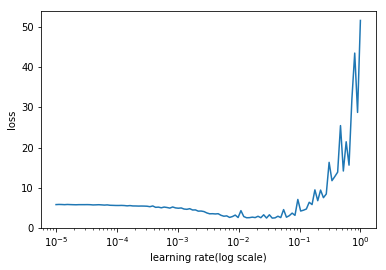

In [78]:
plt.plot(lr_loss_matrix[:, 0], lr_loss_matrix[:, 1])
plt.xlabel('learning rate(log scale)')
plt.ylabel('loss')
plt.xscale('log')
plt.show()

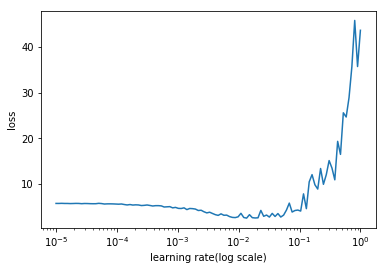

In [32]:
plt.plot(lr_loss_matrix[:, 0], lr_loss_matrix[:, 1])
plt.xlabel('learning rate(log scale)')
plt.ylabel('loss')
plt.xscale('log')
plt.show()

### Learning Rate Scheduler

In [23]:
model = Model1(english_vocab_size, french_vocab_size, max_french_sequence_length, 
                 embedding_dim=200, hidden_dim=100, rnn_module = nn.LSTM)
model_adam = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.03, amsgrad=True)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.5, momentum=1, nesterov=True)

In [148]:
optimizer_sgd = optim.SGD(model.parameters(), lr=0.5, momentum=1, nesterov=True)

#exp_lr_scheduler_anneal = lr_scheduler.CosineAnnealingLR(optimizer=optimizer_sgd, 
#                                                         T_max=400, 
#                                                         eta_min=7.5e-3, 
#                                                         last_epoch=-1)

In [24]:
def lr_decay(epoch):
    lr_matrix = np.ones(1200)
    lr_matrix[0:300] = 0.03
    lr_matrix[300:600] = 0.01
    lr_matrix[600:900] = 7.5e-3
    lr_matrix[900:] = 3e-3
    
    return lr_matrix[epoch]

def lr_decay_sgd(epoch):
    lr_matrix = np.ones(1200)
    lr_matrix[0:300] = 0.5
    lr_matrix[300:600] = 0.25
    lr_matrix[600:900] = 0.1
    lr_matrix[900:] = 0.05
    
    return lr_matrix[epoch]

exp_lr_scheduler = lr_scheduler.LambdaLR(optimizer=optimizer_adam, lr_lambda=lr_decay, last_epoch=-1)
#exp_lr_scheduler_sgd = lr_scheduler.LambdaLR(optimizer=optimizer_sgd, lr_lambda=lr_decay_sgd, last_epoch=-1)

## Training & Validation Loop


Check Input and Output Tensor Shape

In [31]:
a = list(dataloaders['train'])
b = list(dataloaders['test'])
print(len(a), len(b))

108 27


In [32]:
input, label = a[0]

In [33]:
print(input[0].view(1,-1).shape)
print(label[0].view(1,-1).shape)

torch.Size([1, 15])
torch.Size([1, 21])


In [39]:
output = model_adam(input.to(device))

In [40]:
output.shape

torch.Size([1024, 345, 21])

### define training procedure

In [25]:
def mac_train_model(model, criterion, optimizer, scheduler, num_epochs=18):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_matrix = dict()
    loss_matrix['train'] = np.ones(num_epochs)
    loss_matrix['test'] = np.ones(num_epochs)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 24)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode; won't alter to different dropout and BatchNorm weights

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # turn on the tracking history in train and turn off the tracking history in others
                with torch.set_grad_enabled(phase == 'train'): #set gradient calculation enabled
                    outputs = model(inputs)
                    max_tensor, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double()*100 / (dataset_size[phase]*max_french_sequence_length)
            
            # loss matrix to monitor
            loss_matrix[phase][epoch] = epoch_loss
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # Monitor loss matrix
    plt.plot(range(num_epochs), loss_matrix['train'], label='train')
    plt.plot(range(num_epochs), loss_matrix['test'], label='test')
    plt.title('loss optimization monitor')
    plt.xlabel('# of epoch')
    plt.ylabel('optimized loss')
    plt.show()
    
    return model


## Train


Train with Adam with LSTM

Epoch 0/1199
------------------------
train Loss: 3.3676 Acc: 42.0450
test Loss: 2.3153 Acc: 54.9508

Epoch 1/1199
------------------------
train Loss: 2.0877 Acc: 57.4596
test Loss: 1.8834 Acc: 59.5362

Epoch 2/1199
------------------------
train Loss: 1.7560 Acc: 61.5070
test Loss: 1.6068 Acc: 63.2006

Epoch 3/1199
------------------------
train Loss: 1.5358 Acc: 64.6209
test Loss: 1.4386 Acc: 65.9399

Epoch 4/1199
------------------------
train Loss: 1.3444 Acc: 67.8425
test Loss: 1.2839 Acc: 69.4393

Epoch 5/1199
------------------------
train Loss: 1.2427 Acc: 70.5196
test Loss: 1.1787 Acc: 71.4059

Epoch 6/1199
------------------------
train Loss: 1.1292 Acc: 72.9053
test Loss: 1.0532 Acc: 74.3665

Epoch 7/1199
------------------------
train Loss: 1.0155 Acc: 75.4686
test Loss: 0.9921 Acc: 75.8780

Epoch 8/1199
------------------------
train Loss: 0.9533 Acc: 77.0854
test Loss: 0.9080 Acc: 77.7429

Epoch 9/1199
------------------------
train Loss: 0.8814 Acc: 78.6971
test Loss: 0

test Loss: 0.1749 Acc: 96.0597

Epoch 80/1199
------------------------
train Loss: 0.1249 Acc: 97.1018
test Loss: 0.1512 Acc: 96.4458

Epoch 81/1199
------------------------
train Loss: 0.1201 Acc: 97.2083
test Loss: 0.1579 Acc: 96.4123

Epoch 82/1199
------------------------
train Loss: 0.1211 Acc: 97.1996
test Loss: 0.1560 Acc: 96.4811

Epoch 83/1199
------------------------
train Loss: 0.1194 Acc: 97.2482
test Loss: 0.1458 Acc: 96.6153

Epoch 84/1199
------------------------
train Loss: 0.1174 Acc: 97.2769
test Loss: 0.1571 Acc: 96.4581

Epoch 85/1199
------------------------
train Loss: 0.1173 Acc: 97.2746
test Loss: 0.1536 Acc: 96.4287

Epoch 86/1199
------------------------
train Loss: 0.1161 Acc: 97.2832
test Loss: 0.1590 Acc: 96.3735

Epoch 87/1199
------------------------
train Loss: 0.1159 Acc: 97.2984
test Loss: 0.1482 Acc: 96.6068

Epoch 88/1199
------------------------
train Loss: 0.1139 Acc: 97.3873
test Loss: 0.1517 Acc: 96.5186

Epoch 89/1199
------------------------
tr

test Loss: 0.1163 Acc: 97.4942

Epoch 159/1199
------------------------
train Loss: 0.0622 Acc: 98.5598
test Loss: 0.1176 Acc: 97.4197

Epoch 160/1199
------------------------
train Loss: 0.0606 Acc: 98.5674
test Loss: 0.1163 Acc: 97.4121

Epoch 161/1199
------------------------
train Loss: 0.0593 Acc: 98.6196
test Loss: 0.1144 Acc: 97.5325

Epoch 162/1199
------------------------
train Loss: 0.0606 Acc: 98.5961
test Loss: 0.1186 Acc: 97.4339

Epoch 163/1199
------------------------
train Loss: 0.0621 Acc: 98.5498
test Loss: 0.1117 Acc: 97.5370

Epoch 164/1199
------------------------
train Loss: 0.0609 Acc: 98.5775
test Loss: 0.1136 Acc: 97.5187

Epoch 165/1199
------------------------
train Loss: 0.0610 Acc: 98.5996
test Loss: 0.1138 Acc: 97.5546

Epoch 166/1199
------------------------
train Loss: 0.0574 Acc: 98.6691
test Loss: 0.1157 Acc: 97.5125

Epoch 167/1199
------------------------
train Loss: 0.0599 Acc: 98.6215
test Loss: 0.1132 Acc: 97.5759

Epoch 168/1199
-----------------

test Loss: 0.1087 Acc: 97.8413

Epoch 238/1199
------------------------
train Loss: 0.0418 Acc: 99.0427
test Loss: 0.1096 Acc: 97.7144

Epoch 239/1199
------------------------
train Loss: 0.0388 Acc: 99.1106
test Loss: 0.1008 Acc: 97.9850

Epoch 240/1199
------------------------
train Loss: 0.0393 Acc: 99.1211
test Loss: 0.1038 Acc: 97.8994

Epoch 241/1199
------------------------
train Loss: 0.0402 Acc: 99.0935
test Loss: 0.1069 Acc: 97.8467

Epoch 242/1199
------------------------
train Loss: 0.0401 Acc: 99.1067
test Loss: 0.1001 Acc: 97.9728

Epoch 243/1199
------------------------
train Loss: 0.0383 Acc: 99.1417
test Loss: 0.1013 Acc: 98.0021

Epoch 244/1199
------------------------
train Loss: 0.0375 Acc: 99.1691
test Loss: 0.1037 Acc: 97.9584

Epoch 245/1199
------------------------
train Loss: 0.0368 Acc: 99.1805
test Loss: 0.1041 Acc: 97.9790

Epoch 246/1199
------------------------
train Loss: 0.0361 Acc: 99.1699
test Loss: 0.1080 Acc: 97.8420

Epoch 247/1199
-----------------

test Loss: 0.1010 Acc: 98.1206

Epoch 317/1199
------------------------
train Loss: 0.0255 Acc: 99.4684
test Loss: 0.0976 Acc: 98.1417

Epoch 318/1199
------------------------
train Loss: 0.0256 Acc: 99.4591
test Loss: 0.1017 Acc: 98.0861

Epoch 319/1199
------------------------
train Loss: 0.0238 Acc: 99.4974
test Loss: 0.1013 Acc: 98.1204

Epoch 320/1199
------------------------
train Loss: 0.0243 Acc: 99.4927
test Loss: 0.1005 Acc: 98.1548

Epoch 321/1199
------------------------
train Loss: 0.0258 Acc: 99.4619
test Loss: 0.0974 Acc: 98.1878

Epoch 322/1199
------------------------
train Loss: 0.0265 Acc: 99.4477
test Loss: 0.1012 Acc: 98.1063

Epoch 323/1199
------------------------
train Loss: 0.0266 Acc: 99.4669
test Loss: 0.1007 Acc: 98.2253

Epoch 324/1199
------------------------
train Loss: 0.0243 Acc: 99.4923
test Loss: 0.0984 Acc: 98.1645

Epoch 325/1199
------------------------
train Loss: 0.0242 Acc: 99.4894
test Loss: 0.1008 Acc: 98.0733

Epoch 326/1199
-----------------

test Loss: 0.1014 Acc: 98.2106

Epoch 396/1199
------------------------
train Loss: 0.0217 Acc: 99.5488
test Loss: 0.0988 Acc: 98.1952

Epoch 397/1199
------------------------
train Loss: 0.0220 Acc: 99.5481
test Loss: 0.1018 Acc: 98.2277

Epoch 398/1199
------------------------
train Loss: 0.0225 Acc: 99.5271
test Loss: 0.1022 Acc: 98.1323

Epoch 399/1199
------------------------
train Loss: 0.0234 Acc: 99.5206
test Loss: 0.1003 Acc: 98.1063

Epoch 400/1199
------------------------
train Loss: 0.0221 Acc: 99.5413
test Loss: 0.1009 Acc: 98.2323

Epoch 401/1199
------------------------
train Loss: 0.0230 Acc: 99.5338
test Loss: 0.1024 Acc: 98.2170

Epoch 402/1199
------------------------
train Loss: 0.0234 Acc: 99.5214
test Loss: 0.1039 Acc: 98.2189

Epoch 403/1199
------------------------
train Loss: 0.0215 Acc: 99.5605
test Loss: 0.1020 Acc: 98.2220

Epoch 404/1199
------------------------
train Loss: 0.0225 Acc: 99.5339
test Loss: 0.1032 Acc: 98.2379

Epoch 405/1199
-----------------

test Loss: 0.1021 Acc: 98.2736

Epoch 475/1199
------------------------
train Loss: 0.0213 Acc: 99.5689
test Loss: 0.1035 Acc: 98.2322

Epoch 476/1199
------------------------
train Loss: 0.0213 Acc: 99.5669
test Loss: 0.1024 Acc: 98.2370

Epoch 477/1199
------------------------
train Loss: 0.0218 Acc: 99.5532
test Loss: 0.1022 Acc: 98.2277

Epoch 478/1199
------------------------
train Loss: 0.0200 Acc: 99.5850
test Loss: 0.1038 Acc: 98.2493

Epoch 479/1199
------------------------
train Loss: 0.0200 Acc: 99.6037
test Loss: 0.1015 Acc: 98.1911

Epoch 480/1199
------------------------
train Loss: 0.0208 Acc: 99.5836
test Loss: 0.1002 Acc: 98.2251

Epoch 481/1199
------------------------
train Loss: 0.0204 Acc: 99.5833
test Loss: 0.1020 Acc: 98.2151

Epoch 482/1199
------------------------
train Loss: 0.0207 Acc: 99.5900
test Loss: 0.1069 Acc: 98.1643

Epoch 483/1199
------------------------
train Loss: 0.0232 Acc: 99.5118
test Loss: 0.1060 Acc: 98.1420

Epoch 484/1199
-----------------

test Loss: 0.1034 Acc: 98.2434

Epoch 554/1199
------------------------
train Loss: 0.0186 Acc: 99.6330
test Loss: 0.1025 Acc: 98.1900

Epoch 555/1199
------------------------
train Loss: 0.0175 Acc: 99.6488
test Loss: 0.1027 Acc: 98.1957

Epoch 556/1199
------------------------
train Loss: 0.0186 Acc: 99.6288
test Loss: 0.1024 Acc: 98.2715

Epoch 557/1199
------------------------
train Loss: 0.0180 Acc: 99.6422
test Loss: 0.1039 Acc: 98.2313

Epoch 558/1199
------------------------
train Loss: 0.0191 Acc: 99.6228
test Loss: 0.1032 Acc: 98.2297

Epoch 559/1199
------------------------
train Loss: 0.0180 Acc: 99.6338
test Loss: 0.1067 Acc: 98.1886

Epoch 560/1199
------------------------
train Loss: 0.0186 Acc: 99.6239
test Loss: 0.1042 Acc: 98.2513

Epoch 561/1199
------------------------
train Loss: 0.0175 Acc: 99.6418
test Loss: 0.1018 Acc: 98.2627

Epoch 562/1199
------------------------
train Loss: 0.0194 Acc: 99.6103
test Loss: 0.1012 Acc: 98.2710

Epoch 563/1199
-----------------

test Loss: 0.1040 Acc: 98.2919

Epoch 633/1199
------------------------
train Loss: 0.0167 Acc: 99.6695
test Loss: 0.1048 Acc: 98.2824

Epoch 634/1199
------------------------
train Loss: 0.0171 Acc: 99.6678
test Loss: 0.1040 Acc: 98.2529

Epoch 635/1199
------------------------
train Loss: 0.0171 Acc: 99.6624
test Loss: 0.1063 Acc: 98.1980

Epoch 636/1199
------------------------
train Loss: 0.0182 Acc: 99.6391
test Loss: 0.1004 Acc: 98.2645

Epoch 637/1199
------------------------
train Loss: 0.0166 Acc: 99.6776
test Loss: 0.1021 Acc: 98.2555

Epoch 638/1199
------------------------
train Loss: 0.0176 Acc: 99.6554
test Loss: 0.1019 Acc: 98.3094

Epoch 639/1199
------------------------
train Loss: 0.0163 Acc: 99.6824
test Loss: 0.1005 Acc: 98.2703

Epoch 640/1199
------------------------
train Loss: 0.0184 Acc: 99.6453
test Loss: 0.1031 Acc: 98.3076

Epoch 641/1199
------------------------
train Loss: 0.0160 Acc: 99.6899
test Loss: 0.1038 Acc: 98.2536

Epoch 642/1199
-----------------

test Loss: 0.1023 Acc: 98.2234

Epoch 712/1199
------------------------
train Loss: 0.0153 Acc: 99.7017
test Loss: 0.1037 Acc: 98.2962

Epoch 713/1199
------------------------
train Loss: 0.0159 Acc: 99.7000
test Loss: 0.1025 Acc: 98.3094

Epoch 714/1199
------------------------
train Loss: 0.0167 Acc: 99.6624
test Loss: 0.1047 Acc: 98.2772

Epoch 715/1199
------------------------
train Loss: 0.0167 Acc: 99.6743
test Loss: 0.1053 Acc: 98.2874

Epoch 716/1199
------------------------
train Loss: 0.0154 Acc: 99.6964
test Loss: 0.1009 Acc: 98.3002

Epoch 717/1199
------------------------
train Loss: 0.0163 Acc: 99.6884
test Loss: 0.1078 Acc: 98.3080

Epoch 718/1199
------------------------
train Loss: 0.0154 Acc: 99.6980
test Loss: 0.1067 Acc: 98.2377

Epoch 719/1199
------------------------
train Loss: 0.0160 Acc: 99.6906
test Loss: 0.1062 Acc: 98.2959

Epoch 720/1199
------------------------
train Loss: 0.0146 Acc: 99.7235
test Loss: 0.1061 Acc: 98.2120

Epoch 721/1199
-----------------

test Loss: 0.1036 Acc: 98.2949

Epoch 791/1199
------------------------
train Loss: 0.0154 Acc: 99.7010
test Loss: 0.1044 Acc: 98.3164

Epoch 792/1199
------------------------
train Loss: 0.0152 Acc: 99.7113
test Loss: 0.1045 Acc: 98.2919

Epoch 793/1199
------------------------
train Loss: 0.0164 Acc: 99.6913
test Loss: 0.1051 Acc: 98.2812

Epoch 794/1199
------------------------
train Loss: 0.0149 Acc: 99.7152
test Loss: 0.1044 Acc: 98.2778

Epoch 795/1199
------------------------
train Loss: 0.0144 Acc: 99.7193
test Loss: 0.1054 Acc: 98.2588

Epoch 796/1199
------------------------
train Loss: 0.0140 Acc: 99.7303
test Loss: 0.1061 Acc: 98.2936

Epoch 797/1199
------------------------
train Loss: 0.0160 Acc: 99.6987
test Loss: 0.1073 Acc: 98.2529

Epoch 798/1199
------------------------
train Loss: 0.0158 Acc: 99.6918
test Loss: 0.1100 Acc: 98.2831

Epoch 799/1199
------------------------
train Loss: 0.0153 Acc: 99.7028
test Loss: 0.1097 Acc: 98.2695

Epoch 800/1199
-----------------

test Loss: 0.1047 Acc: 98.3030

Epoch 870/1199
------------------------
train Loss: 0.0156 Acc: 99.7040
test Loss: 0.1033 Acc: 98.3171

Epoch 871/1199
------------------------
train Loss: 0.0144 Acc: 99.7323
test Loss: 0.1056 Acc: 98.3410

Epoch 872/1199
------------------------
train Loss: 0.0146 Acc: 99.7264
test Loss: 0.1049 Acc: 98.3765

Epoch 873/1199
------------------------
train Loss: 0.0146 Acc: 99.7255
test Loss: 0.1037 Acc: 98.2876

Epoch 874/1199
------------------------
train Loss: 0.0141 Acc: 99.7299
test Loss: 0.1048 Acc: 98.3299

Epoch 875/1199
------------------------
train Loss: 0.0155 Acc: 99.7118
test Loss: 0.1058 Acc: 98.3272

Epoch 876/1199
------------------------
train Loss: 0.0148 Acc: 99.7228
test Loss: 0.1065 Acc: 98.3437

Epoch 877/1199
------------------------
train Loss: 0.0142 Acc: 99.7328
test Loss: 0.1073 Acc: 98.2968

Epoch 878/1199
------------------------
train Loss: 0.0141 Acc: 99.7310
test Loss: 0.1055 Acc: 98.2969

Epoch 879/1199
-----------------

test Loss: 0.1060 Acc: 98.3385

Epoch 949/1199
------------------------
train Loss: 0.0141 Acc: 99.7313
test Loss: 0.1063 Acc: 98.3296

Epoch 950/1199
------------------------
train Loss: 0.0140 Acc: 99.7434
test Loss: 0.1074 Acc: 98.3332

Epoch 951/1199
------------------------
train Loss: 0.0137 Acc: 99.7419
test Loss: 0.1053 Acc: 98.3396

Epoch 952/1199
------------------------
train Loss: 0.0150 Acc: 99.7224
test Loss: 0.1042 Acc: 98.3183

Epoch 953/1199
------------------------
train Loss: 0.0131 Acc: 99.7602
test Loss: 0.1108 Acc: 98.3285

Epoch 954/1199
------------------------
train Loss: 0.0137 Acc: 99.7447
test Loss: 0.1063 Acc: 98.2876

Epoch 955/1199
------------------------
train Loss: 0.0140 Acc: 99.7399
test Loss: 0.1051 Acc: 98.3550

Epoch 956/1199
------------------------
train Loss: 0.0133 Acc: 99.7519
test Loss: 0.1036 Acc: 98.3278

Epoch 957/1199
------------------------
train Loss: 0.0136 Acc: 99.7486
test Loss: 0.1044 Acc: 98.3493

Epoch 958/1199
-----------------

train Loss: 0.0136 Acc: 99.7544
test Loss: 0.1099 Acc: 98.3800

Epoch 1028/1199
------------------------
train Loss: 0.0127 Acc: 99.7675
test Loss: 0.1070 Acc: 98.3377

Epoch 1029/1199
------------------------
train Loss: 0.0134 Acc: 99.7569
test Loss: 0.1096 Acc: 98.3413

Epoch 1030/1199
------------------------
train Loss: 0.0135 Acc: 99.7519
test Loss: 0.1075 Acc: 98.3467

Epoch 1031/1199
------------------------
train Loss: 0.0147 Acc: 99.7326
test Loss: 0.1074 Acc: 98.2897

Epoch 1032/1199
------------------------
train Loss: 0.0128 Acc: 99.7606
test Loss: 0.1090 Acc: 98.3436

Epoch 1033/1199
------------------------
train Loss: 0.0129 Acc: 99.7566
test Loss: 0.1082 Acc: 98.2802

Epoch 1034/1199
------------------------
train Loss: 0.0139 Acc: 99.7459
test Loss: 0.1061 Acc: 98.3366

Epoch 1035/1199
------------------------
train Loss: 0.0139 Acc: 99.7436
test Loss: 0.1054 Acc: 98.3408

Epoch 1036/1199
------------------------
train Loss: 0.0142 Acc: 99.7383
test Loss: 0.1069 Acc: 

test Loss: 0.1075 Acc: 98.2921

Epoch 1106/1199
------------------------
train Loss: 0.0128 Acc: 99.7742
test Loss: 0.1067 Acc: 98.3582

Epoch 1107/1199
------------------------
train Loss: 0.0126 Acc: 99.7708
test Loss: 0.1049 Acc: 98.3477

Epoch 1108/1199
------------------------
train Loss: 0.0119 Acc: 99.7831
test Loss: 0.1066 Acc: 98.3040

Epoch 1109/1199
------------------------
train Loss: 0.0129 Acc: 99.7593
test Loss: 0.1059 Acc: 98.2645

Epoch 1110/1199
------------------------
train Loss: 0.0125 Acc: 99.7723
test Loss: 0.1044 Acc: 98.3873

Epoch 1111/1199
------------------------
train Loss: 0.0133 Acc: 99.7609
test Loss: 0.1045 Acc: 98.3486

Epoch 1112/1199
------------------------
train Loss: 0.0120 Acc: 99.7795
test Loss: 0.1054 Acc: 98.2862

Epoch 1113/1199
------------------------
train Loss: 0.0124 Acc: 99.7725
test Loss: 0.1069 Acc: 98.3164

Epoch 1114/1199
------------------------
train Loss: 0.0117 Acc: 99.7874
test Loss: 0.1077 Acc: 98.3660

Epoch 1115/1199
-------

train Loss: 0.0124 Acc: 99.7702
test Loss: 0.1100 Acc: 98.3463

Epoch 1185/1199
------------------------
train Loss: 0.0130 Acc: 99.7646
test Loss: 0.1073 Acc: 98.3069

Epoch 1186/1199
------------------------
train Loss: 0.0128 Acc: 99.7693
test Loss: 0.1073 Acc: 98.3608

Epoch 1187/1199
------------------------
train Loss: 0.0120 Acc: 99.7864
test Loss: 0.1067 Acc: 98.3575

Epoch 1188/1199
------------------------
train Loss: 0.0130 Acc: 99.7578
test Loss: 0.1057 Acc: 98.3185

Epoch 1189/1199
------------------------
train Loss: 0.0132 Acc: 99.7592
test Loss: 0.1128 Acc: 98.3056

Epoch 1190/1199
------------------------
train Loss: 0.0136 Acc: 99.7523
test Loss: 0.1048 Acc: 98.3297

Epoch 1191/1199
------------------------
train Loss: 0.0118 Acc: 99.7786
test Loss: 0.1076 Acc: 98.3836

Epoch 1192/1199
------------------------
train Loss: 0.0128 Acc: 99.7683
test Loss: 0.1087 Acc: 98.3551

Epoch 1193/1199
------------------------
train Loss: 0.0129 Acc: 99.7594
test Loss: 0.1084 Acc: 

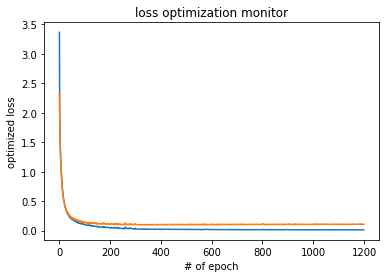

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
model_adam = mac_train_model(model=model_adam, criterion=criterion, optimizer=optimizer_adam, 
                          scheduler=exp_lr_scheduler, num_epochs=1200)
torch.save(model_adam, './data/model_adam_lstm.pt')

Train with Adam with GRU

Epoch 0/1199
------------------------
train Loss: 3.3892 Acc: 42.2490
test Loss: 2.2591 Acc: 55.5413

Epoch 1/1199
------------------------
train Loss: 2.0709 Acc: 57.7959
test Loss: 1.8925 Acc: 59.8556

Epoch 2/1199
------------------------
train Loss: 1.7759 Acc: 61.4404
test Loss: 1.6381 Acc: 63.6080

Epoch 3/1199
------------------------
train Loss: 1.5620 Acc: 64.6518
test Loss: 1.5139 Acc: 65.6121

Epoch 4/1199
------------------------
train Loss: 1.4017 Acc: 67.3450
test Loss: 1.3413 Acc: 68.1970

Epoch 5/1199
------------------------
train Loss: 1.2966 Acc: 69.5813
test Loss: 1.2185 Acc: 70.8312

Epoch 6/1199
------------------------
train Loss: 1.1737 Acc: 71.8680
test Loss: 1.1412 Acc: 72.6961

Epoch 7/1199
------------------------
train Loss: 1.0999 Acc: 73.7919
test Loss: 1.0194 Acc: 74.9225

Epoch 8/1199
------------------------
train Loss: 0.9863 Acc: 76.2859
test Loss: 0.9796 Acc: 76.5886

Epoch 9/1199
------------------------
train Loss: 0.9230 Acc: 77.7390
test Loss: 0

test Loss: 0.1778 Acc: 95.8312

Epoch 80/1199
------------------------
train Loss: 0.1542 Acc: 96.4293
test Loss: 0.1790 Acc: 95.7956

Epoch 81/1199
------------------------
train Loss: 0.1482 Acc: 96.5681
test Loss: 0.1863 Acc: 95.7415

Epoch 82/1199
------------------------
train Loss: 0.1460 Acc: 96.6127
test Loss: 0.1802 Acc: 95.8351

Epoch 83/1199
------------------------
train Loss: 0.1507 Acc: 96.4919
test Loss: 0.1727 Acc: 95.9612

Epoch 84/1199
------------------------
train Loss: 0.1457 Acc: 96.6321
test Loss: 0.1821 Acc: 95.8576

Epoch 85/1199
------------------------
train Loss: 0.1415 Acc: 96.7018
test Loss: 0.1780 Acc: 95.9557

Epoch 86/1199
------------------------
train Loss: 0.1451 Acc: 96.5939
test Loss: 0.1785 Acc: 95.8566

Epoch 87/1199
------------------------
train Loss: 0.1405 Acc: 96.7277
test Loss: 0.1772 Acc: 95.9298

Epoch 88/1199
------------------------
train Loss: 0.1423 Acc: 96.6752
test Loss: 0.1775 Acc: 95.8849

Epoch 89/1199
------------------------
tr

test Loss: 0.1352 Acc: 96.9621

Epoch 159/1199
------------------------
train Loss: 0.0869 Acc: 97.9369
test Loss: 0.1419 Acc: 96.7505

Epoch 160/1199
------------------------
train Loss: 0.0999 Acc: 97.5753
test Loss: 0.1469 Acc: 96.6156

Epoch 161/1199
------------------------
train Loss: 0.0958 Acc: 97.6761
test Loss: 0.1407 Acc: 96.7135

Epoch 162/1199
------------------------
train Loss: 0.0880 Acc: 97.8899
test Loss: 0.1309 Acc: 96.9862

Epoch 163/1199
------------------------
train Loss: 0.0883 Acc: 97.8823
test Loss: 0.1343 Acc: 96.8906

Epoch 164/1199
------------------------
train Loss: 0.0854 Acc: 97.9711
test Loss: 0.1293 Acc: 97.0615

Epoch 165/1199
------------------------
train Loss: 0.0824 Acc: 98.0294
test Loss: 0.1298 Acc: 97.0824

Epoch 166/1199
------------------------
train Loss: 0.0824 Acc: 98.0110
test Loss: 0.1318 Acc: 97.0520

Epoch 167/1199
------------------------
train Loss: 0.0802 Acc: 98.0810
test Loss: 0.1313 Acc: 97.0441

Epoch 168/1199
-----------------

test Loss: 0.1248 Acc: 97.2593

Epoch 238/1199
------------------------
train Loss: 0.0666 Acc: 98.3706
test Loss: 0.1191 Acc: 97.4507

Epoch 239/1199
------------------------
train Loss: 0.0596 Acc: 98.5635
test Loss: 0.1162 Acc: 97.4301

Epoch 240/1199
------------------------
train Loss: 0.0611 Acc: 98.5356
test Loss: 0.1178 Acc: 97.4261

Epoch 241/1199
------------------------
train Loss: 0.0641 Acc: 98.4565
test Loss: 0.1210 Acc: 97.3645

Epoch 242/1199
------------------------
train Loss: 0.0630 Acc: 98.4838
test Loss: 0.1267 Acc: 97.1702

Epoch 243/1199
------------------------
train Loss: 0.0650 Acc: 98.4265
test Loss: 0.1195 Acc: 97.4439

Epoch 244/1199
------------------------
train Loss: 0.0634 Acc: 98.4850
test Loss: 0.1187 Acc: 97.4665

Epoch 245/1199
------------------------
train Loss: 0.0627 Acc: 98.4917
test Loss: 0.1214 Acc: 97.3130

Epoch 246/1199
------------------------
train Loss: 0.0605 Acc: 98.5402
test Loss: 0.1212 Acc: 97.3056

Epoch 247/1199
-----------------

test Loss: 0.1082 Acc: 97.7038

Epoch 317/1199
------------------------
train Loss: 0.0427 Acc: 99.0265
test Loss: 0.1032 Acc: 97.8453

Epoch 318/1199
------------------------
train Loss: 0.0416 Acc: 99.0540
test Loss: 0.1087 Acc: 97.7712

Epoch 319/1199
------------------------
train Loss: 0.0429 Acc: 99.0365
test Loss: 0.1061 Acc: 97.8453

Epoch 320/1199
------------------------
train Loss: 0.0433 Acc: 99.0142
test Loss: 0.1063 Acc: 97.8109

Epoch 321/1199
------------------------
train Loss: 0.0434 Acc: 99.0252
test Loss: 0.1050 Acc: 97.8660

Epoch 322/1199
------------------------
train Loss: 0.0405 Acc: 99.0839
test Loss: 0.1049 Acc: 97.8168

Epoch 323/1199
------------------------
train Loss: 0.0416 Acc: 99.0562
test Loss: 0.1046 Acc: 97.8667

Epoch 324/1199
------------------------
train Loss: 0.0424 Acc: 99.0457
test Loss: 0.1074 Acc: 97.7740

Epoch 325/1199
------------------------
train Loss: 0.0396 Acc: 99.0905
test Loss: 0.1076 Acc: 97.8209

Epoch 326/1199
-----------------

test Loss: 0.1072 Acc: 97.9130

Epoch 396/1199
------------------------
train Loss: 0.0389 Acc: 99.1206
test Loss: 0.1070 Acc: 97.8173

Epoch 397/1199
------------------------
train Loss: 0.0358 Acc: 99.1829
test Loss: 0.1065 Acc: 97.8726

Epoch 398/1199
------------------------
train Loss: 0.0362 Acc: 99.1787
test Loss: 0.1070 Acc: 97.9253

Epoch 399/1199
------------------------
train Loss: 0.0383 Acc: 99.1472
test Loss: 0.1086 Acc: 97.7969

Epoch 400/1199
------------------------
train Loss: 0.0371 Acc: 99.1554
test Loss: 0.1038 Acc: 97.8850

Epoch 401/1199
------------------------
train Loss: 0.0364 Acc: 99.1628
test Loss: 0.1072 Acc: 97.8859

Epoch 402/1199
------------------------
train Loss: 0.0369 Acc: 99.1720
test Loss: 0.1061 Acc: 97.8988

Epoch 403/1199
------------------------
train Loss: 0.0378 Acc: 99.1351
test Loss: 0.1076 Acc: 97.8695

Epoch 404/1199
------------------------
train Loss: 0.0355 Acc: 99.1906
test Loss: 0.1082 Acc: 97.8733

Epoch 405/1199
-----------------

test Loss: 0.1061 Acc: 97.8318

Epoch 475/1199
------------------------
train Loss: 0.0358 Acc: 99.1732
test Loss: 0.1069 Acc: 97.8315

Epoch 476/1199
------------------------
train Loss: 0.0362 Acc: 99.1810
test Loss: 0.1066 Acc: 97.8940

Epoch 477/1199
------------------------
train Loss: 0.0328 Acc: 99.2405
test Loss: 0.1050 Acc: 97.9410

Epoch 478/1199
------------------------
train Loss: 0.0352 Acc: 99.2027
test Loss: 0.1072 Acc: 97.8861

Epoch 479/1199
------------------------
train Loss: 0.0341 Acc: 99.2422
test Loss: 0.1038 Acc: 97.9766

Epoch 480/1199
------------------------
train Loss: 0.0356 Acc: 99.1981
test Loss: 0.1052 Acc: 97.9132

Epoch 481/1199
------------------------
train Loss: 0.0345 Acc: 99.2319
test Loss: 0.1037 Acc: 97.9353

Epoch 482/1199
------------------------
train Loss: 0.0365 Acc: 99.1792
test Loss: 0.1063 Acc: 97.9548

Epoch 483/1199
------------------------
train Loss: 0.0364 Acc: 99.1791
test Loss: 0.1063 Acc: 97.8681

Epoch 484/1199
-----------------

test Loss: 0.1088 Acc: 97.8515

Epoch 554/1199
------------------------
train Loss: 0.0339 Acc: 99.2415
test Loss: 0.1087 Acc: 97.9099

Epoch 555/1199
------------------------
train Loss: 0.0313 Acc: 99.2831
test Loss: 0.1070 Acc: 97.8928

Epoch 556/1199
------------------------
train Loss: 0.0332 Acc: 99.2376
test Loss: 0.1098 Acc: 97.9275

Epoch 557/1199
------------------------
train Loss: 0.0332 Acc: 99.2466
test Loss: 0.1062 Acc: 97.9327

Epoch 558/1199
------------------------
train Loss: 0.0332 Acc: 99.2481
test Loss: 0.1090 Acc: 97.9173

Epoch 559/1199
------------------------
train Loss: 0.0300 Acc: 99.3194
test Loss: 0.1078 Acc: 97.9095

Epoch 560/1199
------------------------
train Loss: 0.0306 Acc: 99.2955
test Loss: 0.1076 Acc: 97.9234

Epoch 561/1199
------------------------
train Loss: 0.0333 Acc: 99.2482
test Loss: 0.1070 Acc: 97.9289

Epoch 562/1199
------------------------
train Loss: 0.0317 Acc: 99.2823
test Loss: 0.1068 Acc: 97.9729

Epoch 563/1199
-----------------

test Loss: 0.1110 Acc: 97.8133

Epoch 633/1199
------------------------
train Loss: 0.0344 Acc: 99.2143
test Loss: 0.1095 Acc: 97.8728

Epoch 634/1199
------------------------
train Loss: 0.0322 Acc: 99.2451
test Loss: 0.1073 Acc: 97.9387

Epoch 635/1199
------------------------
train Loss: 0.0319 Acc: 99.2631
test Loss: 0.1103 Acc: 97.9258

Epoch 636/1199
------------------------
train Loss: 0.0339 Acc: 99.2131
test Loss: 0.1061 Acc: 97.9180

Epoch 637/1199
------------------------
train Loss: 0.0312 Acc: 99.2868
test Loss: 0.1071 Acc: 97.8945

Epoch 638/1199
------------------------
train Loss: 0.0310 Acc: 99.3063
test Loss: 0.1068 Acc: 97.9741

Epoch 639/1199
------------------------
train Loss: 0.0306 Acc: 99.3125
test Loss: 0.1068 Acc: 97.9918

Epoch 640/1199
------------------------
train Loss: 0.0305 Acc: 99.3179
test Loss: 0.1056 Acc: 97.9596

Epoch 641/1199
------------------------
train Loss: 0.0306 Acc: 99.3077
test Loss: 0.1041 Acc: 97.9829

Epoch 642/1199
-----------------

test Loss: 0.1094 Acc: 97.9095

Epoch 712/1199
------------------------
train Loss: 0.0278 Acc: 99.3903
test Loss: 0.1085 Acc: 97.9418

Epoch 713/1199
------------------------
train Loss: 0.0278 Acc: 99.3833
test Loss: 0.1085 Acc: 98.0351

Epoch 714/1199
------------------------
train Loss: 0.0277 Acc: 99.3805
test Loss: 0.1051 Acc: 98.0482

Epoch 715/1199
------------------------
train Loss: 0.0283 Acc: 99.3714
test Loss: 0.1094 Acc: 97.9501

Epoch 716/1199
------------------------
train Loss: 0.0286 Acc: 99.3642
test Loss: 0.1078 Acc: 97.9838

Epoch 717/1199
------------------------
train Loss: 0.0273 Acc: 99.3939
test Loss: 0.1095 Acc: 98.0234

Epoch 718/1199
------------------------
train Loss: 0.0264 Acc: 99.3993
test Loss: 0.1052 Acc: 98.0448

Epoch 719/1199
------------------------
train Loss: 0.0283 Acc: 99.3759
test Loss: 0.1101 Acc: 97.9318

Epoch 720/1199
------------------------
train Loss: 0.0266 Acc: 99.4060
test Loss: 0.1082 Acc: 98.0113

Epoch 721/1199
-----------------

test Loss: 0.1083 Acc: 98.0382

Epoch 791/1199
------------------------
train Loss: 0.0264 Acc: 99.4092
test Loss: 0.1086 Acc: 97.9705

Epoch 792/1199
------------------------
train Loss: 0.0266 Acc: 99.4196
test Loss: 0.1080 Acc: 97.9943

Epoch 793/1199
------------------------
train Loss: 0.0280 Acc: 99.3700
test Loss: 0.1078 Acc: 98.0268

Epoch 794/1199
------------------------
train Loss: 0.0295 Acc: 99.3557
test Loss: 0.1128 Acc: 97.9106

Epoch 795/1199
------------------------
train Loss: 0.0371 Acc: 99.1497
test Loss: 0.1142 Acc: 97.8570

Epoch 796/1199
------------------------
train Loss: 0.0335 Acc: 99.2182
test Loss: 0.1105 Acc: 97.8743

Epoch 797/1199
------------------------
train Loss: 0.0326 Acc: 99.2645
test Loss: 0.1105 Acc: 97.9335

Epoch 798/1199
------------------------
train Loss: 0.0298 Acc: 99.3245
test Loss: 0.1111 Acc: 97.8931

Epoch 799/1199
------------------------
train Loss: 0.0297 Acc: 99.3216
test Loss: 0.1094 Acc: 97.9638

Epoch 800/1199
-----------------

test Loss: 0.1119 Acc: 97.9835

Epoch 870/1199
------------------------
train Loss: 0.0276 Acc: 99.3843
test Loss: 0.1086 Acc: 98.0401

Epoch 871/1199
------------------------
train Loss: 0.0254 Acc: 99.4432
test Loss: 0.1080 Acc: 98.0033

Epoch 872/1199
------------------------
train Loss: 0.0263 Acc: 99.4303
test Loss: 0.1094 Acc: 98.0102

Epoch 873/1199
------------------------
train Loss: 0.0246 Acc: 99.4495
test Loss: 0.1112 Acc: 97.9753

Epoch 874/1199
------------------------
train Loss: 0.0263 Acc: 99.4235
test Loss: 0.1119 Acc: 97.9769

Epoch 875/1199
------------------------
train Loss: 0.0279 Acc: 99.3851
test Loss: 0.1112 Acc: 98.0080

Epoch 876/1199
------------------------
train Loss: 0.0255 Acc: 99.4404
test Loss: 0.1068 Acc: 98.0460

Epoch 877/1199
------------------------
train Loss: 0.0253 Acc: 99.4366
test Loss: 0.1102 Acc: 97.9935

Epoch 878/1199
------------------------
train Loss: 0.0259 Acc: 99.4292
test Loss: 0.1107 Acc: 98.0023

Epoch 879/1199
-----------------

test Loss: 0.1089 Acc: 98.0529

Epoch 949/1199
------------------------
train Loss: 0.0237 Acc: 99.4877
test Loss: 0.1105 Acc: 97.9658

Epoch 950/1199
------------------------
train Loss: 0.0251 Acc: 99.4473
test Loss: 0.1093 Acc: 98.0258

Epoch 951/1199
------------------------
train Loss: 0.0230 Acc: 99.5051
test Loss: 0.1096 Acc: 97.9959

Epoch 952/1199
------------------------
train Loss: 0.0231 Acc: 99.4964
test Loss: 0.1093 Acc: 98.0486

Epoch 953/1199
------------------------
train Loss: 0.0248 Acc: 99.4644
test Loss: 0.1124 Acc: 98.0111

Epoch 954/1199
------------------------
train Loss: 0.0250 Acc: 99.4566
test Loss: 0.1083 Acc: 97.9888

Epoch 955/1199
------------------------
train Loss: 0.0236 Acc: 99.4764
test Loss: 0.1085 Acc: 98.0643

Epoch 956/1199
------------------------
train Loss: 0.0246 Acc: 99.4602
test Loss: 0.1108 Acc: 98.0102

Epoch 957/1199
------------------------
train Loss: 0.0237 Acc: 99.4757
test Loss: 0.1109 Acc: 97.9762

Epoch 958/1199
-----------------

train Loss: 0.0233 Acc: 99.4920
test Loss: 0.1102 Acc: 97.9612

Epoch 1028/1199
------------------------
train Loss: 0.0227 Acc: 99.4996
test Loss: 0.1126 Acc: 98.0173

Epoch 1029/1199
------------------------
train Loss: 0.0244 Acc: 99.4666
test Loss: 0.1109 Acc: 97.9522

Epoch 1030/1199
------------------------
train Loss: 0.0272 Acc: 99.4066
test Loss: 0.1075 Acc: 98.0101

Epoch 1031/1199
------------------------
train Loss: 0.0264 Acc: 99.4320
test Loss: 0.1114 Acc: 97.9935

Epoch 1032/1199
------------------------
train Loss: 0.0243 Acc: 99.4662
test Loss: 0.1075 Acc: 98.0418

Epoch 1033/1199
------------------------
train Loss: 0.0219 Acc: 99.5257
test Loss: 0.1081 Acc: 98.0845

Epoch 1034/1199
------------------------
train Loss: 0.0233 Acc: 99.4911
test Loss: 0.1038 Acc: 98.0710

Epoch 1035/1199
------------------------
train Loss: 0.0234 Acc: 99.4908
test Loss: 0.1119 Acc: 97.9928

Epoch 1036/1199
------------------------
train Loss: 0.0231 Acc: 99.4907
test Loss: 0.1087 Acc: 

test Loss: 0.1137 Acc: 98.0090

Epoch 1106/1199
------------------------
train Loss: 0.0224 Acc: 99.5257
test Loss: 0.1122 Acc: 98.0584

Epoch 1107/1199
------------------------
train Loss: 0.0242 Acc: 99.4767
test Loss: 0.1144 Acc: 98.0272

Epoch 1108/1199
------------------------
train Loss: 0.0230 Acc: 99.4960
test Loss: 0.1132 Acc: 98.0313

Epoch 1109/1199
------------------------
train Loss: 0.0243 Acc: 99.4742
test Loss: 0.1111 Acc: 98.0779

Epoch 1110/1199
------------------------
train Loss: 0.0228 Acc: 99.5124
test Loss: 0.1143 Acc: 98.0850

Epoch 1111/1199
------------------------
train Loss: 0.0235 Acc: 99.4921
test Loss: 0.1140 Acc: 98.0384

Epoch 1112/1199
------------------------
train Loss: 0.0236 Acc: 99.4937
test Loss: 0.1114 Acc: 98.0503

Epoch 1113/1199
------------------------
train Loss: 0.0246 Acc: 99.4791
test Loss: 0.1108 Acc: 98.0266

Epoch 1114/1199
------------------------
train Loss: 0.0237 Acc: 99.4975
test Loss: 0.1120 Acc: 98.0408

Epoch 1115/1199
-------

train Loss: 0.0220 Acc: 99.5191
test Loss: 0.1129 Acc: 98.0534

Epoch 1185/1199
------------------------
train Loss: 0.0218 Acc: 99.5276
test Loss: 0.1071 Acc: 98.0503

Epoch 1186/1199
------------------------
train Loss: 0.0215 Acc: 99.5376
test Loss: 0.1116 Acc: 98.0114

Epoch 1187/1199
------------------------
train Loss: 0.0238 Acc: 99.4881
test Loss: 0.1138 Acc: 98.0961

Epoch 1188/1199
------------------------
train Loss: 0.0229 Acc: 99.5054
test Loss: 0.1130 Acc: 97.9842

Epoch 1189/1199
------------------------
train Loss: 0.0223 Acc: 99.5099
test Loss: 0.1120 Acc: 97.9627

Epoch 1190/1199
------------------------
train Loss: 0.0231 Acc: 99.4858
test Loss: 0.1126 Acc: 97.9874

Epoch 1191/1199
------------------------
train Loss: 0.0222 Acc: 99.5212
test Loss: 0.1126 Acc: 97.9940

Epoch 1192/1199
------------------------
train Loss: 0.0237 Acc: 99.4842
test Loss: 0.1139 Acc: 98.0786

Epoch 1193/1199
------------------------
train Loss: 0.0227 Acc: 99.5123
test Loss: 0.1116 Acc: 

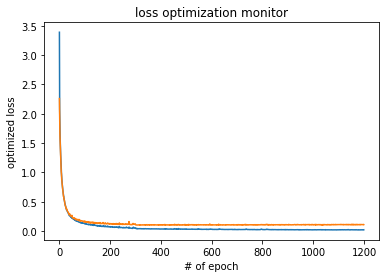

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Model1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [46]:
final_model = mac_train_model(model=model_adam, criterion=criterion, optimizer=optimizer_adam, 
                          scheduler=exp_lr_scheduler, num_epochs=1200)
torch.save(final_model, './data/model_adam_gru.pt')

## Validation

In [27]:
x_tk = english_tokenizer
y_tk = french_tokenizer
x_id_to_word = {value: key for key, value in x_tk.word_index.items()}
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
x_id_to_word[0] = '<PAD>'
y_id_to_word[0] = '<PAD>'

In [28]:
len(x_id_to_word)

200

In [35]:
index = 11
pred_input = input[index].view(1,-1) 
#print(pred_input.shape)
pred_input = pred_input.numpy()
pred_input.reshape(-1)

#model_adam = torch.load('./data/model_adam.pt')
#model_adam = model_adam.to(device)
output = model_adam(input[index].view(1,-1).to(device))

pred_output = output.data.view(french_vocab_size+1, max_french_sequence_length).cpu().numpy()
#print(pred_output.shape)
pred_output[0]

target_output = label[index].numpy()

x_tk = english_tokenizer
y_tk = french_tokenizer
x_id_to_word = {value: key for key, value in x_tk.word_index.items()}
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
x_id_to_word[0] = '<PAD>'
y_id_to_word[0] = '<PAD>'
x_id_to_word[pred_input.reshape(-1)[0]]
print(' '.join([x_id_to_word[x] for x in pred_input.reshape(-1)]))
print(' '.join([y_id_to_word[x] for x in np.argmax(pred_output, axis=0)]))
print('correct French sentence')
print(' '.join([y_id_to_word[x] for x in target_output]))


your favorite fruit is the grapefruit but their favorite is the mango <PAD> <PAD> <PAD>
votre fruit préféré est le pamplemousse mais leur favori est la mangue <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
correct French sentence
votre fruit préféré est le pamplemousse mais leur favori est la mangue <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


#### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [ ]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?